# Downloading the Dataset

In [1]:
import requests

# URLs for the dataset
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes"

# Download the files
response_train = requests.get(train_url)
response_test = requests.get(test_url)

# Save the files to the Colab environment
with open("pendigits.tra", "wb") as f:
    f.write(response_train.content)

with open("pendigits.tes", "wb") as f:
  f.write(response_test.content)

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


# Loading and Parsing the Dataset

In [2]:
import numpy as np

# Load training data
with open("pendigits.tra", "r") as f:
    train_data = f.readlines()

# Load test data
with open("pendigits.tes", "r") as f:
    test_data = f.readlines()

# Function to parse the data
def parse_data(data):
    X = []
    y = []
    for line in data:
        values = line.strip().split(',')
        X.append([float(x) for x in values[:-1]])
        y.append(int(values[-1]))
    return np.array(X), np.array(y)

# Parse training and test data
X_train, y_train = parse_data(train_data)
X_test, y_test = parse_data(test_data)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (7494, 16)
Test data shape: (3498, 16)


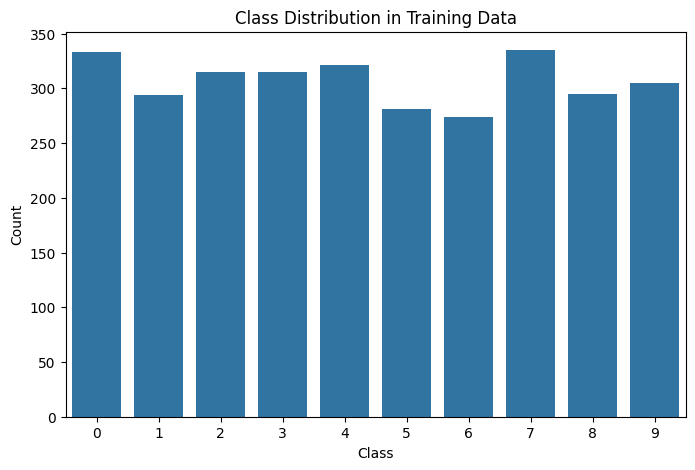

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

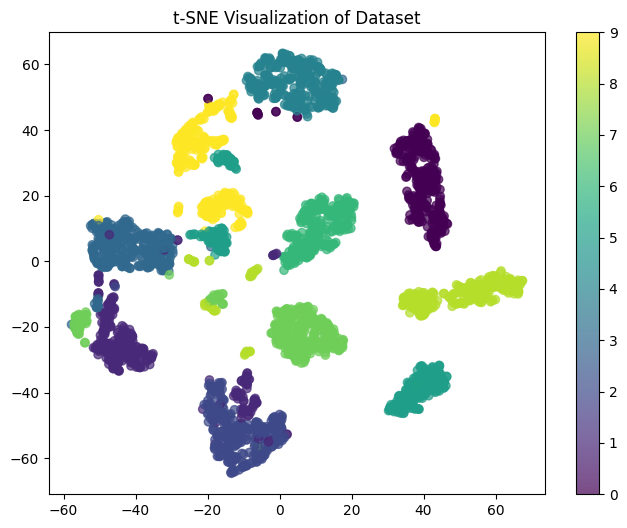

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization of Dataset")
plt.colorbar()
plt.show()

In [7]:
import numpy as np
import sys

class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.
    optimizer : str (default: 'sgd')
        Optimization algorithm to use. Options: 'sgd', 'momentum', 'adam'.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None, optimizer='sgd'):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.optimizer = optimizer
        n_features = X_train.shape[1]
        n_output=np.unique(y_train).shape[0]

        # Initialize optimizer-specific parameters
        if self.optimizer == 'momentum':
            self.momentum = 0.9
            self.delta_w_h_prev = np.zeros((n_features, self.n_hidden))
            self.delta_b_h_prev = np.zeros(self.n_hidden)
            self.delta_w_out_prev = np.zeros((self.n_hidden, n_output))
            self.delta_b_out_prev = np.zeros(n_output)
        elif self.optimizer == 'adam':
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.m_w_h = np.zeros((n_features, self.n_hidden))
            self.v_w_h = np.zeros((n_features, self.n_hidden))
            self.m_b_h = np.zeros(self.n_hidden)
            self.v_b_h = np.zeros(self.n_hidden)
            self.m_w_out = np.zeros((self.n_hidden, n_output))
            self.v_w_out = np.zeros((self.n_hidden, n_output))
            self.m_b_out = np.zeros(n_output)
            self.v_b_out = np.zeros(n_output)

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation"""
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function."""
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """Predict class labels"""
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data."""
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                delta_out = a_out - y_train_enc[batch_idx]
                sigmoid_derivative_h = a_h * (1. - a_h)
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized

                if self.optimizer == 'sgd':
                    self.w_h -= self.eta * delta_w_h
                    self.b_h -= self.eta * delta_b_h
                    self.w_out -= self.eta * delta_w_out
                    self.b_out -= self.eta * delta_b_out

                elif self.optimizer == 'momentum':
                    self.delta_w_h_prev = self.momentum * self.delta_w_h_prev - self.eta * delta_w_h
                    self.delta_b_h_prev = self.momentum * self.delta_b_h_prev - self.eta * delta_b_h
                    self.w_h += self.delta_w_h_prev
                    self.b_h += self.delta_b_h_prev

                    self.delta_w_out_prev = self.momentum * self.delta_w_out_prev - self.eta * delta_w_out
                    self.delta_b_out_prev = self.momentum * self.delta_b_out_prev - self.eta * delta_b_out
                    self.w_out += self.delta_w_out_prev
                    self.b_out += self.delta_b_out_prev

                elif self.optimizer == 'adam':
                    self.m_w_h = self.beta1 * self.m_w_h + (1 - self.beta1) * delta_w_h
                    self.v_w_h = self.beta2 * self.v_w_h + (1 - self.beta2) * (delta_w_h ** 2)
                    m_w_h_hat = self.m_w_h / (1 - self.beta1 ** (i + 1))
                    v_w_h_hat = self.v_w_h / (1 - self.beta2 ** (i + 1))
                    self.w_h -= self.eta * m_w_h_hat / (np.sqrt(v_w_h_hat) + self.epsilon)

                    self.m_b_h = self.beta1 * self.m_b_h + (1 - self.beta1) * delta_b_h
                    self.v_b_h = self.beta2 * self.v_b_h + (1 - self.beta2) * (delta_b_h ** 2)
                    m_b_h_hat = self.m_b_h / (1 - self.beta1 ** (i + 1))
                    v_b_h_hat = self.v_b_h / (1 - self.beta2 ** (i + 1))
                    self.b_h -= self.eta * m_b_h_hat / (np.sqrt(v_b_h_hat) + self.epsilon)

                    self.m_w_out = self.beta1 * self.m_w_out + (1 - self.beta1) * delta_w_out
                    self.v_w_out = self.beta2 * self.v_w_out + (1 - self.beta2) * (delta_w_out ** 2)
                    m_w_out_hat = self.m_w_out / (1 - self.beta1 ** (i + 1))
                    v_w_out_hat = self.v_w_out / (1 - self.beta2 ** (i + 1))
                    self.w_out -= self.eta * m_w_out_hat / (np.sqrt(v_w_out_hat) + self.epsilon)

                    self.m_b_out = self.beta1 * self.m_b_out + (1 - self.beta1) * delta_b_out
                    self.v_b_out = self.beta2 * self.v_b_out + (1 - self.beta2) * (delta_b_out ** 2)
                    m_b_out_hat = self.m_b_out / (1 - self.beta1 ** (i + 1))
                    v_b_out_hat = self.v_b_out / (1 - self.beta2 ** (i + 1))
                    self.b_out -= self.eta * m_b_out_hat / (np.sqrt(v_b_out_hat) + self.epsilon)

            #############
            # Evaluation
            #############

            z_h, a_h, z_out, a_out = self._forward(X_train)

            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Normalize features to [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train NeuralNetMLP
nn = NeuralNetMLP(n_hidden=50, epochs=200, eta=0.01, minibatch_size=10, shuffle=True, seed=42)
nn.fit(X_train, y_train, X_valid, y_valid)

# Make predictions
y_pred = nn.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

200/200 | Cost: 270.26 | Train/Valid Acc.: 99.43%/98.75% 


Test Accuracy: 96.71%


In [9]:
# Initialize and train NeuralNetMLP
nn = NeuralNetMLP(n_hidden=50, epochs=200, eta=0.01, minibatch_size=10, shuffle=True, seed=42, optimizer='momentum')
nn.fit(X_train, y_train, X_valid, y_valid)

# Make predictions
y_pred = nn.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

200/200 | Cost: 26.49 | Train/Valid Acc.: 99.93%/98.70% 


Test Accuracy: 97.54%


In [10]:
# Initialize and train NeuralNetMLP
nn = NeuralNetMLP(n_hidden=50, epochs=200, eta=0.01, minibatch_size=10, shuffle=True, seed=42, optimizer='adam')
nn.fit(X_train, y_train, X_valid, y_valid)

# Make predictions
y_pred = nn.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

200/200 | Cost: 50.84 | Train/Valid Acc.: 99.90%/98.83% 


Test Accuracy: 97.48%


In [26]:

for i in range(len(X_test)):
  if y_pred[i]!=y_test[i]:
    print('!!',y_pred[i], '-----', y_test[i])





!! 9 ----- 3
!! 2 ----- 1
!! 5 ----- 6
!! 5 ----- 4
!! 9 ----- 8
!! 5 ----- 4
!! 7 ----- 9
!! 8 ----- 0
!! 2 ----- 1
!! 2 ----- 1
!! 1 ----- 3
!! 5 ----- 4
!! 3 ----- 5
!! 8 ----- 0
!! 5 ----- 4
!! 5 ----- 9
!! 1 ----- 7
!! 8 ----- 0
!! 1 ----- 7
!! 5 ----- 4
!! 8 ----- 0
!! 9 ----- 7
!! 5 ----- 4
!! 8 ----- 6
!! 5 ----- 8
!! 1 ----- 7
!! 9 ----- 7
!! 1 ----- 7
!! 8 ----- 0
!! 2 ----- 1
!! 9 ----- 7
!! 7 ----- 1
!! 4 ----- 1
!! 1 ----- 9
!! 2 ----- 7
!! 8 ----- 0
!! 9 ----- 5
!! 9 ----- 5
!! 1 ----- 7
!! 5 ----- 3
!! 8 ----- 0
!! 9 ----- 7
!! 0 ----- 6
!! 7 ----- 2
!! 2 ----- 7
!! 7 ----- 9
!! 2 ----- 1
!! 4 ----- 7
!! 8 ----- 6
!! 5 ----- 4
!! 2 ----- 1
!! 8 ----- 0
!! 8 ----- 0
!! 5 ----- 4
!! 1 ----- 7
!! 8 ----- 0
!! 8 ----- 0
!! 1 ----- 7
!! 8 ----- 9
!! 9 ----- 5
!! 8 ----- 0
!! 1 ----- 2
!! 8 ----- 0
!! 9 ----- 7
!! 5 ----- 4
!! 1 ----- 7
!! 8 ----- 0
!! 8 ----- 0
!! 3 ----- 5
!! 1 ----- 7
!! 8 ----- 0
!! 9 ----- 3
!! 8 ----- 0
!! 9 ----- 5
!! 5 ----- 6
!! 7 ----- 9
!! 8 ----- 0